In [2]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
import bitstring
from qiskit_aer import AerSimulator
from qiskit.transpiler.passes.synthesis import SolovayKitaev
from qiskit.synthesis import generate_basic_approximations
from qiskit.quantum_info import Operator

from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

from qiskit.circuit.library import UnitaryGate

In [48]:
qc = QuantumCircuit(1)

qc.rz(np.pi/8, 0)

print("Original circuit:")
print(qc.draw())
 
basis = ["t", "tdg", "z", "h"]
approx = generate_basic_approximations(basis, depth=3)
skd = SolovayKitaev(recursion_degree=2, basic_approximations=approx)
 
discretized = skd(qc)
 
print("Discretized circuit:")
print(discretized.draw())
 
print("Error:", np.linalg.norm(Operator(qc).data - Operator(discretized).data))

#discretized.draw("mpl")

Original circuit:
   ┌─────────┐
q: ┤ Rz(π/8) ├
   └─────────┘
Discretized circuit:
   ┌───┐┌───┐┌─────┐┌───┐┌─────┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌─────┐┌───┐»
q: ┤ T ├┤ H ├┤ Tdg ├┤ H ├┤ Tdg ├┤ H ├┤ T ├┤ H ├┤ T ├┤ H ├┤ T ├┤ H ├┤ Tdg ├┤ H ├»
   └───┘└───┘└─────┘└───┘└─────┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└─────┘└───┘»
«   ┌─────┐┌───┐
«q: ┤ Tdg ├┤ H ├
«   └─────┘└───┘
Error: 0.07944281142466891


In [49]:
qc = QuantumCircuit(1)

qc.rz(-np.pi/8, 0)

print("Original circuit:")
print(qc.draw())
 
basis = ["t", "tdg", "z", "h"]
approx = generate_basic_approximations(basis, depth=3)
skd = SolovayKitaev(recursion_degree=2, basic_approximations=approx)
 
discretized1 = skd(qc)
 
print("Discretized circuit:")
print(discretized1.draw())
 
print("Error:", np.linalg.norm(Operator(qc).data - Operator(discretized1).data))

#discretized.draw("mpl")

Original circuit:
   ┌──────────┐
q: ┤ Rz(-π/8) ├
   └──────────┘
Discretized circuit:
   ┌───┐┌───┐┌───┐┌───┐┌───┐┌─────┐┌───┐┌─────┐┌───┐┌─────┐┌───┐┌───┐┌───┐┌───┐»
q: ┤ H ├┤ T ├┤ H ├┤ T ├┤ H ├┤ Tdg ├┤ H ├┤ Tdg ├┤ H ├┤ Tdg ├┤ H ├┤ T ├┤ H ├┤ T ├»
   └───┘└───┘└───┘└───┘└───┘└─────┘└───┘└─────┘└───┘└─────┘└───┘└───┘└───┘└───┘»
«   ┌───┐┌─────┐
«q: ┤ H ├┤ Tdg ├
«   └───┘└─────┘
Error: 0.07944281142466901


In [6]:
def root_T(qc: QuantumCircuit, pos):
    circ = QuantumCircuit(1)
    circ.rz(np.pi/8, 0)
    basis = ["t", "tdg", "z", "h"]
    approx = generate_basic_approximations(basis, depth=3)
    skd = SolovayKitaev(recursion_degree=2, basic_approximations=approx)
    discretized = skd(circ)
    hmm = discretized.data
    for instruction in hmm:
        if instruction.name == "t":
            qc.t(pos)
        if instruction.name == "tdg":
            qc.tdg(pos)
        if instruction.name == "h":
            qc.h(pos)

def adj_root_T(qc: QuantumCircuit, pos):
    circ = QuantumCircuit(1)
    circ.rz(-np.pi/8, 0)
    basis = ["t", "tdg", "z", "h"]
    approx = generate_basic_approximations(basis, depth=3)
    skd = SolovayKitaev(recursion_degree=2, basic_approximations=approx)
    discretized = skd(circ)
    hmm = discretized.data
    for instruction in hmm:
        if instruction.name == "t":
            qc.t(pos)
        if instruction.name == "tdg":
            qc.tdg(pos)
        if instruction.name == "h":
            qc.h(pos)

def CT(qc: QuantumCircuit):
    root_T(qc, 0)
    root_T(qc, 1)
    qc.cx(0,1)
    adj_root_T(qc,1)
    qc.cx(0,1)

In [13]:
qr = QuantumRegister(2,"q")
cbits = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cbits)

qc.x(1)
qc.h(0)

CT(qc)
CT(qc)
CT(qc)
CT(qc)

qc.h(0)
qc.measure(0,0)

sim = AerSimulator()
    
job = sim.run(qc, shots=10000)

result = job.result()
counts = result.get_counts()

print(counts)

#qc.draw("mpl")

/home/dustinseboldt/.local/lib/python3.10/site-packages/qiskit/synthesis/discrete_basis/generate_basis_approximations.py:61: RuntimeWarning: The SolovayKitaev algorithm relies on scikit-learn's KDTree for a fast search over the basis approximations. Without this, we fallback onto a greedy search with is significantly slower. We highly suggest to install scikit-learn to use this feature.
  warnings.warn(


{'0': 209, '1': 9791}


{'1': 1463652, '0': 8536348}


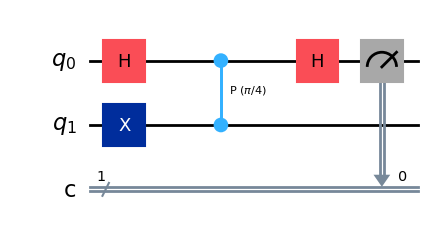

In [63]:
qr = QuantumRegister(2,"q")
cbits = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cbits)

qc.x(1)
qc.h(0)

qc.cp(np.pi/4, 0, 1)

# qc.p(np.pi/8, 0)
# qc.p(np.pi/8, 1)
# qc.cx(0,1)
# qc.p(-np.pi/8,1)
# qc.cx(0,1)


# solovay(qc, discretized=discretized, pos=0)
# solovay(qc, discretized=discretized, pos=1)
# qc.cx(0,1)
# solovay(qc, discretized=discretized1, pos=1)
# qc.cx(0,1)



qc.h(0)
qc.measure(0,0)

sim = AerSimulator()
    
job = sim.run(qc, shots=10000000)

result = job.result()
counts = result.get_counts()

print(counts)

qc.draw("mpl")

{'1': 10000}


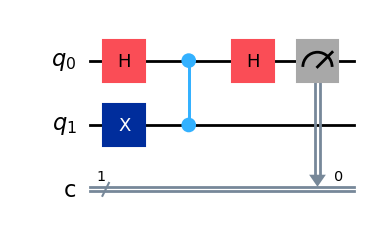

In [3]:
#iQPE first iteration

qr = QuantumRegister(2,"q")
cbits = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cbits)

qc.x(1)
qc.h(0)

qc.cz(0,1)

qc.h(0)
qc.measure(0,0)

sim = AerSimulator()
    
job = sim.run(qc, shots=10000)

result = job.result()
counts = result.get_counts()

print(counts)

qc.draw("mpl")

{'0': 10000}


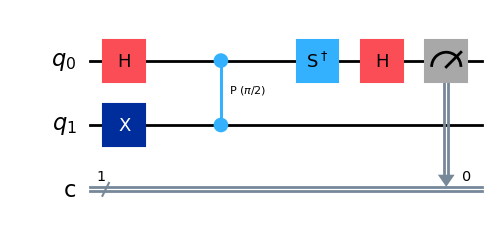

In [10]:
#iQPE second iteration

qr = QuantumRegister(2,"q")
cbits = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cbits)

qc.x(1)
qc.h(0)

qc.cp(np.pi/2,0,1)

qc.sdg(0)

qc.h(0)
qc.measure(0,0)

sim = AerSimulator()
    
job = sim.run(qc, shots=10000)

result = job.result()
counts = result.get_counts()

print(counts)

qc.draw("mpl")

OrderedDict([('x', 1), ('h', 1)])
OrderedDict([('h', 2), ('x', 1), ('cp', 1), ('tdg', 1)])
{'0': 10000}


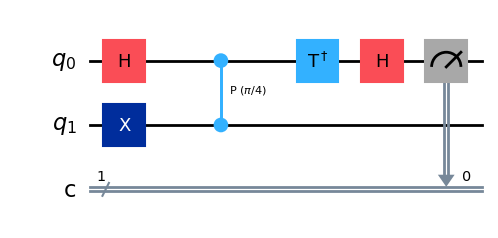

In [45]:
#iQPE third iteration

qr = QuantumRegister(2,"q")
cbits = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cbits)

qc.x(1)
qc.h(0)


qc.cp(np.pi/4,0,1)

qc.tdg(0)

qc.h(0)
qc.measure(0,0)

sim = AerSimulator()
    
job = sim.run(qc, shots=10000)

result = job.result()
counts = result.get_counts()

print(counts)

qc.draw("mpl")

{'1': 5170, '0': 94830}


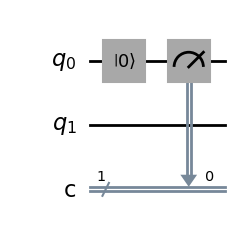

In [41]:
p = 0.1
p_error = pauli_error([["X",p/2],["I",1-p],["Z",p/2]])
p_error_2 = pauli_error([["XI",p/4],["IX",p/4],["II",1-p],["ZI",p/4],["IZ",p/4]])

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(p_error, ["reset"])  # Apply to single-qubit gates

#iQPE third iteration

qr = QuantumRegister(2,"q")
cbits = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cbits)

qc.reset(0)
qc.measure(0,0)

sim = AerSimulator()
    
job = sim.run(qc, shots=100000, noise_model=noise_model)

result = job.result()
counts = result.get_counts()

print(counts)

qc.draw("mpl")